# Affiliation extraction

Adapted from code by Diego Charrez

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import json
from collections import defaultdict
from string_sim import cos_sim_pair

## Text scrape

In [3]:
data_folder = "data/neurips_2019/meta/"
out_folder = "out/neurips_2019/"
data_fname = data_folder + "raw_data_090819_edit.txt"

In [4]:
!head -2 "data/neurips_2019/meta/raw_data_090819_edit.txt"
!tail -2 "data/neurips_2019/meta/raw_data_090819_edit.txt"

<p><b>Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation</b><br><i>Risto Vuorio (University of Michigan) &middot; Shao-Hua Sun (University of Southern California) &middot; Hexiang Hu (University of Southern California) &middot; Joseph Lim (University of Southern California)</i></p>
      <p><b>ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks</b><br><i>Jiasen Lu (Georgia Tech) &middot; Dhruv Batra (Georgia Tech / Facebook AI Research (FAIR)) &middot; Devi Parikh (Georgia Tech / Facebook AI Research (FAIR)) &middot; Stefan Lee (Georgia Institute of Technology)</i></p>
      <p><b>Enabling hyperparameter optimization in sequential autoencoders for spiking neural data</b><br><i>Mohammad Reza Keshtkaran (Georgia Tech and Emory University) &middot; Chethan Pandarinath (Emory University and Georgia Tech)</i></p>
      <p><b>A Meta-Analysis of Overfitting in Machine Learning</b><br><i>Rebecca Roelofs (University of California, Berk

In [5]:
raw_affiliations = list()
titles = list()
raw_authors = list()
pattern = '(\([A-z\.,/ ]+\(.*?\)[A-z\.,/ ]+\)|\(.*?\(?\)?\))' # '\(.*?\)'  # '(\([A-z\.,/ ]+\(.*?\)[A-z\.,/ ]+\)|\(.*?\(?\)?\))'
with open(data_fname, 'r') as file:
    for paper in file:
        soup = BeautifulSoup(paper, features="html.parser")
        italic = soup.i.get_text()
        raw_authors.append(italic)
        raw_affiliations.append(''.join(re.findall(pattern, italic)))
        titles.append(soup.b.get_text())

In [6]:
len(raw_affiliations), len(''.join(raw_affiliations)), raw_affiliations[:5]

(1430,
 123896,
 ['(University of Michigan)(University of Southern California)(University of Southern California)(University of Southern California)',
  '(Georgia Tech)(Georgia Tech / Facebook AI Research (FAIR))(Georgia Tech / Facebook AI Research (FAIR))(Georgia Institute of Technology)',
  '(University of California, Davis)(University of California, Davis)(UCLA)(UC Davis)',
  '(The University of Adelaide)(Tusimple)(Hong Kong University of Science and Technology)(The University of Adelaide)(University of Adelaide)(Nankai University)(University of Adelaide)',
  '(Seoul National University)(Seoul National University)'])

In [7]:
titles[:5]

['Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation',
 'ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks',
 'Stochastic Shared Embeddings: Data-driven Regularization of Embedding Layers',
 'Unsupervised Scale-consistent Depth and Ego-motion Learning from Monocular Video',
 'Zero-shot Learning via Simultaneous Generating and Learning']

In [8]:
raw_authors[:5]

['Risto Vuorio (University of Michigan) · Shao-Hua Sun (University of Southern California) · Hexiang Hu (University of Southern California) · Joseph Lim (University of Southern California)',
 'Jiasen Lu (Georgia Tech) · Dhruv Batra (Georgia Tech / Facebook AI Research (FAIR)) · Devi Parikh (Georgia Tech / Facebook AI Research (FAIR)) · Stefan Lee (Georgia Institute of Technology)',
 'Liwei Wu (University of California, Davis) · Shuqing Li (University of California, Davis) · Cho-Jui Hsieh (UCLA) · James Sharpnack (UC Davis)',
 'Jiawang Bian (The University of Adelaide) · Zhichao Li (Tusimple) · Naiyan Wang (Hong Kong University of Science and Technology) · Huangying Zhan (The University of Adelaide) · Chunhua Shen (University of Adelaide) · Ming-Ming Cheng (Nankai University) · Ian Reid (University of Adelaide)',
 'Hyeonwoo Yu (Seoul National University) · Beomhee Lee (Seoul National University)']

## All affiliations

In [9]:
def load_json(fname):
    with open(fname, 'r') as f:
        data = json.load(f)
    return data

def write_json(fname, output, indent=4):
    with open(fname, 'w') as f:
        json.dump(output, f, indent=indent)

In [10]:
def title_nearest_neighbours(titles, names):
    # name example: '8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation'
    # matching title: 'Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation'
    # non-matching title: 'ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks'

    nn = defaultdict(lambda: (-1, 0.0))
    neighbours = defaultdict(list)
    
    for i, title in enumerate(titles):
        for j, name in enumerate(names):
            name_ = ' '.join(name.split('-')[1:])
            title_ = title.lower().strip()
            title_ = re.sub('[-]', ' ', title_)
            title_ = re.sub('[\(\):,?]', '', title_)
            
            sim = cos_sim_pair(name_, title_)
            
            sim = round(sim, 4)
            neighbours[j].append((i, sim))
            if sim > nn[j][1]:
                nn[j] = (i, sim)
                
    return nn, neighbours

In [11]:
def process_affiliations(name_idx, nn):
    '''
    Extract a clean list of affiliations from the raw affiliation data
    that corresponds to `name_idx`, using nearest-neighbour table `nn`.
    '''
    # Get the entry index `i` in the raw data, such that
    # the paper _title_ that corresponds to `i` is most similar 
    # to the paper _filename_ that corresponds to `name_idx`.
    i = nn[name_idx]
    affiliations = raw_affiliations[i]
    # Split on the intervening brackets (should always work for well-formed data)
    affiliations = affiliations.split(')(')
    # Remove end brackets
    affiliations[0] = affiliations[0][1:]
    affiliations[-1] = affiliations[-1][:-1]
    return affiliations

In [12]:
metadata_fname = out_folder + 'papers_metadata.json'
output_fname = out_folder + 'affiliations.json'

In [13]:
metadatas = load_json(metadata_fname)

In [14]:
names = list()
for metadata in metadatas:
    names.append(os.path.split(metadata['pdf'])[1].replace('.pdf', ''))

**WARNING**: below cell is expensive to compute. Run once and then load the result thereafter.

In [15]:
# nn, neighbours = title_nearest_neighbours(titles, names)
# write_json(out_folder + 'nn.json', nn, indent=4)
# write_json(out_folder + 'title_similarity.json', neighbours, indent=None)

In [16]:
nn = load_json(out_folder + 'nn.json')
nn = {int(k): v[0] for k, v in nn.items()}
# Manually correct mismatches
nn_correction = {1379: 63, 83: 1360, 451: 994, 92: 1347, 870: 569, 681: 763, 135: 1309, 1373: 65, 1060: 381, 1168: 273, 956: 488, 560: 884, 605: 832, 1117: 325, 64: 1384, 245: 1198, 1419: 9, 93: 1352, 1084: 356, 1343: 99, 100: 1341}
for j, i in nn_correction.items():
    nn[j] = i
# Invert mapping
inv_nn = {v: k for k, v in nn.items()}

In [17]:
len(nn)

1428

In [18]:
for k, v in list(nn.items())[:5]:
    print(names[k])
    print(titles[v])

8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation
Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation
8319-generalized-sliced-wasserstein-distances
Generalized Sliced Wasserstein Distances
8318-asymptotic-guarantees-for-learning-generative-models-with-the-sliced-wasserstein-distance
Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance
8321-blind-super-resolution-kernel-estimation-using-an-internal-gan
Blind Super-Resolution Kernel Estimation using an Internal-GAN
8325-provable-gradient-variance-guarantees-for-black-box-variational-inference
Provable Gradient Variance Guarantees for Black-Box Variational Inference


In [19]:
for k, v in list(inv_nn.items())[:5]:
    print(titles[k])
    print(names[v])

Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation
8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation
Generalized Sliced Wasserstein Distances
8319-generalized-sliced-wasserstein-distances
Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance
8318-asymptotic-guarantees-for-learning-generative-models-with-the-sliced-wasserstein-distance
Blind Super-Resolution Kernel Estimation using an Internal-GAN
8321-blind-super-resolution-kernel-estimation-using-an-internal-gan
Provable Gradient Variance Guarantees for Black-Box Variational Inference
8325-provable-gradient-variance-guarantees-for-black-box-variational-inference


In [20]:
output = list()
for i, metadata in enumerate(metadatas):
    pdf_fname = os.path.split(metadata['pdf'])[1]
    paper_id = pdf_fname.split('-')[0]
    
    affiliations = process_affiliations(i, nn)

    has_code = metadata['code']
    data = {
        'name': pdf_fname.replace('.pdf', ''),
        'code': has_code,
        'affiliations': affiliations
    }
    output.append(data)

#     if i > 5: break

write_json(output_fname, output)

## Results on a selection of institutions

In [21]:
affiliation_data = load_json(output_fname)
len(affiliation_data)

1428

In [22]:
institutions = {
    'Amazon': [0, 0, 'amazon', 'industry'],
    'Carnegie Mellon University': [0, 0, 'CMU, Carnegie Mellon University', 'academy'],
    'Columbia University': [0, 0, 'columbia university', 'academy'],
    'Cornell University': [0, 0, 'cornell', 'academy'],
    # 'DeepMind': [0, 0, 'deepmind', 'industry'],
    'Duke University': [0, 0, 'duke', 'academy'],
    'EPFL': [0, 0, 'EPFL', 'academy'],
    'ETH Zurich': [0, 0, 'ETH Zurich, ETHZ, ETH Zürich', 'academy'],
    'Facebook AI Research': [0, 0, 'facebook', 'industry'],
    'Georgia Institute of Technology': [0, 0, 'georgia tech, gatech, Georgia Institute of Technology', 'academy'],
    # 'Google, Google Brain': [0, 0, 'google', 'industry'],
    'Google, Google Brain, DeepMind': [0, 0, 'google, deepmind', 'industry'],
    'Harvard University': [0, 0, 'harvard', 'academy'],
    'IBM research': [0, 0, 'ibm', 'industry'],
    'INRIA': [0, 0, 'inria', 'academy'],
    'Imperial College London': [0, 0, 'imperial', 'academy'],
    'MILA': [0, 0, 'mila', 'academy'],
    'Massachusetts Institute of Technology': [0, 0, 'mit, massachusetts institute of technology', 'academy'],
    'Microsoft Research': [0, 0, 'microsoft', 'industry'],
    'New York University': [0, 0, 'nyu, New York University', 'academy'],
    'Peking University': [0, 0, 'peking university', 'academy'],
    'Princeton University': [0, 0, 'princeton', 'academy'],
    'RIKEN': [0, 0, 'riken', 'industry'],
    'Rutgers': [0, 0, 'Rutgers', 'academy'],
    'Stanford University': [0, 0, 'stanford', 'academy'],
    'Tencent': [0, 0, 'Tencent', 'industry'],
    'Tsinghua University': [0, 0, 'tsinghua', 'academy'],
    'University of California, Berkeley': [0, 0, 'berkeley', 'academy'],
    'University of California, Los Angeles': [0, 0, 'ucla, University of California Los Angeles', 'academy'],
    'University of Cambridge': [0, 0, 'university of cambridge', 'academy'],
    'University of Illinois at Urbana-Champaign': [0, 0, 'uiuc, University of Illinois at Urbana', 'academy'],
    'University of Massachusetts Amherst': [0, 0, 'Amherst', 'academy'],
    'University of Oxford': [0, 0, 'oxford', 'academy'],
    'University of Southern California': [0, 0, 'University of Southern California, USC', 'academy'],
    'University of Texas at Austin': [0, 0, 'University of Texas at Austin, UAT, UT-Austin, UT Austin', 'academy'],
    'University of Toronto': [0, 0, 'University of Toronto, uoft', 'academy'],
    'University of Washington': [0, 0, 'University of Washington', 'academy'],
    'covariant': [0, 0, 'covariant', 'industry'],
    'nvidia': [0, 0, 'nvidia', 'industry'],
    'uber': [0, 0, 'uber', 'industry']
}

In [23]:
missed = list()
for i, _ in enumerate(raw_affiliations):
    try:
        j = inv_nn[i]
    except KeyError as e:
        missed.append(i)
        print(f'Missed at index {i}: {titles[i]} | {raw_authors[i]}')
        continue

    entry = affiliation_data[j]

    # All author affiliations
    affiliations = entry['affiliations']

    # Or select specific authors
    # indices = [-1]
    # affiliations = [entry['affiliations'][k] for k in indices]

    affs = ' '.join([a.lower() for a in affiliations])

    for key in institutions:
        flag = False
        for keyword in institutions[key][2].split(", "):
            if keyword.lower() in affs:
                flag = True
        if flag:
            code = entry['code']  # whether code released
            institutions[key][0] += int(code)  # no. papers with code
            institutions[key][1] += 1  # no. papers

Missed at index 114: Gated CRF Loss for Weakly Supervised Semantic Image Segmentation | Anton Obukhov (ETH Zurich) · Stamatios Georgoulis (ETH Zurich) · Dengxin Dai (ETH Zurich) · Luc V Gool (Computer Vision Lab, ETH Zurich)
Missed at index 1255: A First-Order Approach to Accelerated Value Iteration | Julien Grand Clement (IEOR Department, Columbia University) · Vineet Goyal (Columbia University)


In [24]:
institutions

{'Amazon': [19, 24, 'amazon', 'industry'],
 'Carnegie Mellon University': [65,
  83,
  'CMU, Carnegie Mellon University',
  'academy'],
 'Columbia University': [36, 45, 'columbia university', 'academy'],
 'Cornell University': [27, 32, 'cornell', 'academy'],
 'Duke University': [12, 22, 'duke', 'academy'],
 'EPFL': [23, 24, 'EPFL', 'academy'],
 'ETH Zurich': [19, 25, 'ETH Zurich, ETHZ, ETH Zürich', 'academy'],
 'Facebook AI Research': [33, 43, 'facebook', 'industry'],
 'Georgia Institute of Technology': [21,
  30,
  'georgia tech, gatech, Georgia Institute of Technology',
  'academy'],
 'Google, Google Brain, DeepMind': [101, 170, 'google, deepmind', 'industry'],
 'Harvard University': [20, 24, 'harvard', 'academy'],
 'IBM research': [22, 36, 'ibm', 'industry'],
 'INRIA': [31, 36, 'inria', 'academy'],
 'Imperial College London': [16, 16, 'imperial', 'academy'],
 'MILA': [27, 29, 'mila', 'academy'],
 'Massachusetts Institute of Technology': [63,
  86,
  'mit, massachusetts institute of 

In [25]:
df = pd.DataFrame.from_dict(institutions, orient='index', columns=['code', 'papers', 'keywords', 'category'])
df['code_fraction'] = df.code / df.papers
df = df.sort_values(by=['papers'], ascending=False)
df

,code,papers,keywords,category,code_fraction
"Google, Google Brain, DeepMind",101,170,"google, deepmind",industry,0.594118
Massachusetts Institute of Technology,63,86,"mit, massachusetts institute of technology",academy,0.732558
Stanford University,66,85,stanford,academy,0.776471
Carnegie Mellon University,65,83,"CMU, Carnegie Mellon University",academy,0.783133
Microsoft Research,53,76,microsoft,industry,0.697368
"University of California, Berkeley",43,58,berkeley,academy,0.741379
Princeton University,24,54,princeton,academy,0.444444
Columbia University,36,45,columbia university,academy,0.800000
Facebook AI Research,33,43,facebook,industry,0.767442
University of Oxford,36,41,oxford,academy,0.878049


In [26]:
df.to_csv(out_folder + 'code_release_select.csv')

In [27]:
df_tot = df.sum()
df_tot.code / df_tot.papers

0.7443181818181818

In [28]:
df.mean()

code             27.578947
papers           37.052632
code_fraction     0.785285
dtype: float64

In [29]:
df_cat = df.groupby(['category']).sum()
df_cat['code_fraction'] = df_cat.code / df_cat.papers
df_cat

,code,papers,code_fraction
category,,,
academy,759,991,0.765893
industry,289,417,0.693046


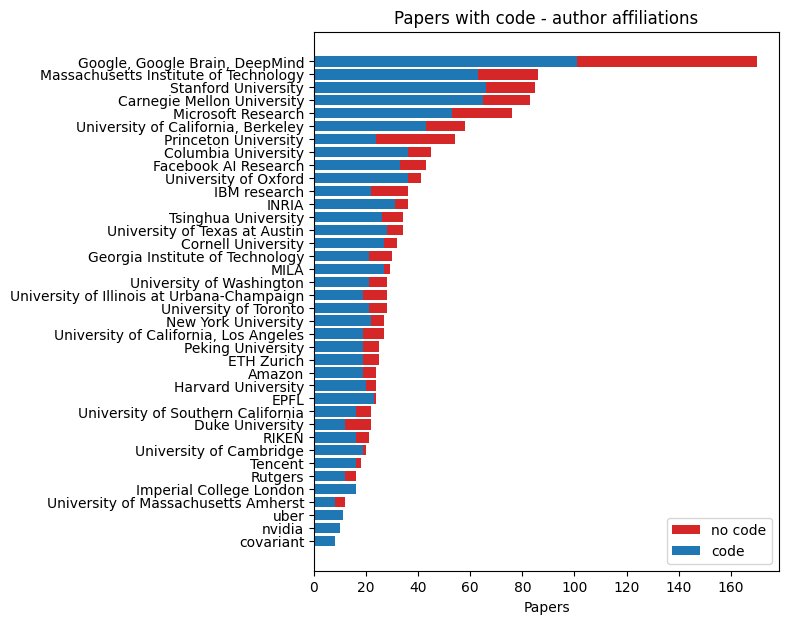

In [30]:
plt.rcdefaults()
fig, ax1 = plt.subplots(figsize=(6, 7))

institution_names = list(df.index.values)
paper_counts = df['papers'].tolist()
code_counts = df['code'].tolist()

ax1.barh(institution_names, paper_counts, color='tab:red')
ax1.barh(institution_names, code_counts, color='tab:blue')
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Papers')
ax1.set_title('Papers with code - author affiliations')
ax1.legend(['no code', 'code'])

plt.savefig(out_folder + 'papers_with_code.png', bbox_inches='tight')
plt.show()